In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/online_retail_II.csv", encoding="latin1")

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
df.shape
#(satır sayısı, kolon sayısı)


(1067371, 8)

In [5]:
df.info()
#Kolon Bilgileri

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [6]:
df.isnull().sum()
#eksik değer analizi

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [7]:
df["Quantity"].describe()


count    1.067371e+06
mean     9.938898e+00
std      1.727058e+02
min     -8.099500e+04
25%      1.000000e+00
50%      3.000000e+00
75%      1.000000e+01
max      8.099500e+04
Name: Quantity, dtype: float64

In [8]:
df["Price"].describe()


count    1.067371e+06
mean     4.649388e+00
std      1.235531e+02
min     -5.359436e+04
25%      1.250000e+00
50%      2.100000e+00
75%      4.150000e+00
max      3.897000e+04
Name: Price, dtype: float64

In [9]:
df = df.dropna(subset=["Customer ID"])


In [10]:
df = df[df["Quantity"] > 0]


In [11]:
df = df[df["Price"] > 0]


In [12]:
df = df[~df["Invoice"].astype(str).str.contains("C")]


In [13]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [14]:
df.shape


(805549, 8)

In [15]:
df["InvoiceDate"].max()


Timestamp('2011-12-09 12:50:00')

In [16]:
# RFM tablosu
rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (df["InvoiceDate"].max() - x.max()).days,  # Recency
    "Invoice": "count",                                                 # Frequency
    "Price": lambda x: (x * df.loc[x.index, "Quantity"]).sum()          # Monetary
})


In [17]:
rfm.columns = ["Recency", "Frequency", "Monetary"]


In [18]:
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,325,34,77556.46
12347.0,1,253,5633.32
12348.0,74,51,2019.40
12349.0,18,175,4428.69
12350.0,309,17,334.40


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


In [20]:
import pandas as pd
rfm_scaled_df = pd.DataFrame(rfm_scaled, 
                             index=rfm.index, 
                             columns=["Recency", "Frequency", "Monetary"])
rfm_scaled_df.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,0.595584,-0.291261,5.058050
12347.0,-0.952279,0.327753,0.177431
12348.0,-0.603532,-0.243210,-0.067806
12349.0,-0.871064,0.107282,0.095686
12350.0,0.519146,-0.339312,-0.182148


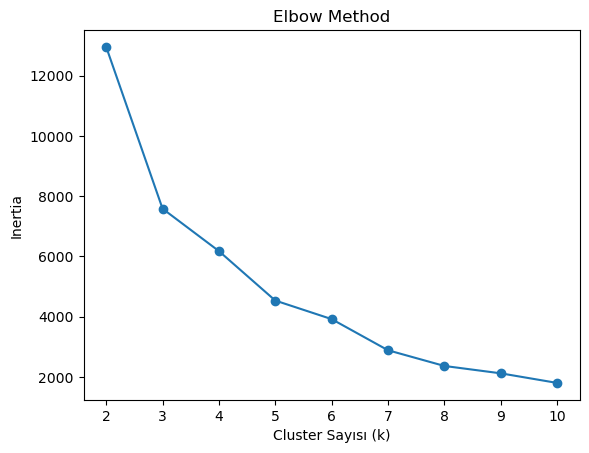

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

k_values = range(2, 11)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)

plt.plot(k_values, inertia, marker="o")
plt.xlabel("Cluster Sayısı (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [23]:
from sklearn.cluster import KMeans

k = 4  # seçtiğimiz cluster sayısı
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(rfm_scaled)

rfm["Cluster"] = kmeans.labels_
rfm.head()


,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.0,325,34,77556.46,1
12347.0,1,253,5633.32,3
12348.0,74,51,2019.40,3
12349.0,18,175,4428.69,3
12350.0,309,17,334.40,0


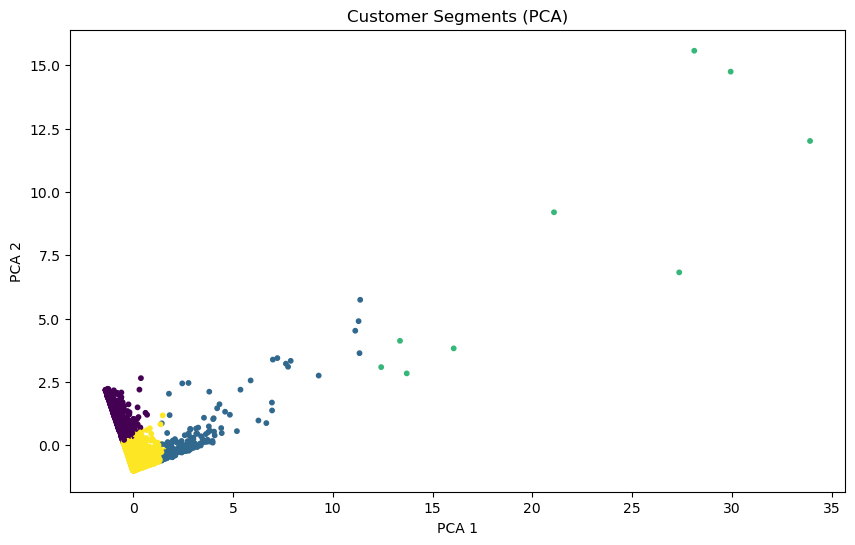

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
components = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(10,6))
plt.scatter(components[:,0], components[:,1], c=rfm["Cluster"], cmap="viridis", s=10)
plt.title("Customer Segments (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [25]:
rfm.groupby("Cluster").mean()


,Recency,Frequency,Monetary
Cluster,,,
0,467.778465,42.929418,757.317256
1,26.269912,929.570796,25158.963735
2,1.555556,6269.888889,231958.182222
3,71.216099,123.098595,2296.036451


In [26]:
segment_map = {
    2: "VIP / High Value",
    1: "Loyal Customers",
    3: "Potential Loyalists",
    0: "Lost Customers"
}

rfm["Segment"] = rfm["Cluster"].map(segment_map)
rfm.head()


,Recency,Frequency,Monetary,Cluster,Segment
Customer ID,,,,,
12346.0,325,34,77556.46,1,Loyal Customers
12347.0,1,253,5633.32,3,Potential Loyalists
12348.0,74,51,2019.40,3,Potential Loyalists
12349.0,18,175,4428.69,3,Potential Loyalists
12350.0,309,17,334.40,0,Lost Customers
